In [1]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plot_time_series.py



In [1]:
%%capture output
!unzip Model.zip

In [2]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
import subprocess
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

from plot_time_series import plot_times_series, load_sto_file
from neural_simulations import run_neural_simulations
from activation import decode_spikes_to_activation


[info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
Simulation complete. Data saved to muscle_output.sto.
     spikes_times_II_0  spikes_times_II_1  spikes_times_II_2  \
0                  0.0                0.0                0.0   
1                  0.0                0.0                0.0   
2                  0.0                0.0                0.0   
3                  0.0                0.0                0.0   
4                  0.0                0.0                0.0   
..                 ...                ...                ...   
255                0.0                0.0                0.0   
256                0.0                0.0                0.0   
257                0.0                0.0                0.0   
258                0.0                0.0                0.0   
259                0.0                0.0                0.0   

     spikes_times_II_3  spik

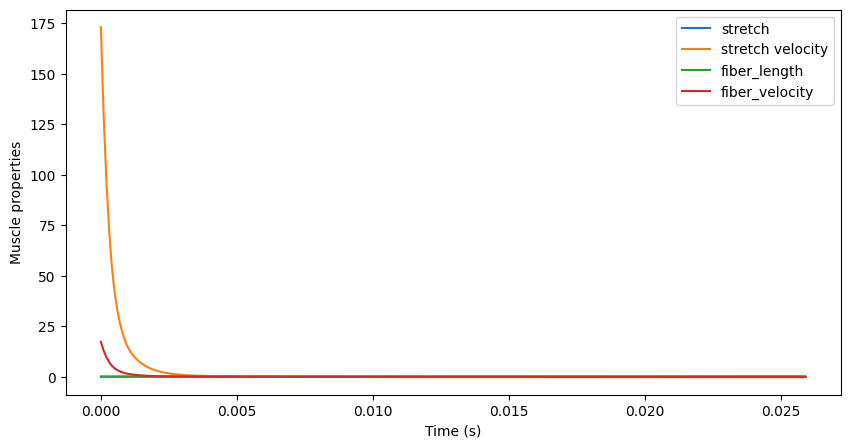

ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 1000x1000 with 0 Axes>

In [37]:
t_stretching_afferent = 16*ms
t_motoneuron_muscle = 10*ms
t_reaction = t_stretching_afferent + t_motoneuron_muscle
n_loop = 1
dt = 0.1*ms

name_activation = 'activation.npy'#input  opensim script
name_output_opensim = 'muscle_output.sto'#output  opensim script
name_output = 'time_series.csv'#final output

neuron_population = {"Ia": 10, "II": 10, "exc": 10, "motor": 10}

# Initialize stretch and velocity arrays
stretch_init = np.zeros(int(t_reaction/dt))
velocity_init = np.zeros(int(t_reaction/dt))
stretch = stretch_init
velocity = velocity_init

data = []
for j in range(n_loop):

    spikes_Ia, spikes_II,spikes_motoneuron= run_neural_simulations(stretch, velocity, neuron_population=neuron_population, dt=dt,T=t_reaction, w=500*uS, p=0.4 )
    dt_second=dt/second #decode_spikes_to_activatio and opensim does not accept time with units
    t_reaction_second= t_reaction/second
    activations=decode_spikes_to_activation(spikes_motoneuron, dt_second, t_reaction_second)
    mean_activation = np.mean(activations, axis=0)
    np.save(name_activation, mean_activation)
    !source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && python muscle_sim.py --dt {dt_second} --T {t_reaction_second} --activation {name_activation}  --output {name_output_opensim}

    table = load_sto_file(name_output_opensim)[:-1] #don't include the last element

    # Create batch data dictionary
    batch_data = {
        **{f'spikes_times_II_{i}': spikes_Ia[i] for i in range(neuron_population['II'])},
        **{f'spikes_times_Ia_{i}': spikes_II[i] for i in range(neuron_population['Ia'])},
        **{f'spikes_times_motoneuron_{i}': spikes_motoneuron[i] for i in range(neuron_population['motor'])},
        **{f'activation{i}': activations[i] for i in range(neuron_population['motor'])},
        'mean_activation': mean_activation,
        'stretch': table['stretch'].values,
        'velocity': table['velocity'].values,
        'fiber_length': table['fiber_length'].values,
        'fiber_velocity': table['fiber_velocity'].values
    }

    data.append(pd.DataFrame(batch_data))

# Create DataFrame and apply time shifts
df = pd.concat(data)

df['Time']=df.index*dt_second
# Save the DataFrame to CSV
df.to_csv(name_output, index=False)

# Plot time series
plot_times_series(name_output)